# Calculating hydrogen bond lifetimes

We will calculate the lifetime of intramolecular hydrogen bonds in a protein.

**Last updated:** June 23, 2021 with MDAnalysis 2.0.0-dev

**Minimum version of MDAnalysis:** 2.0.0-dev0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests
* [numpy](https://numpy.org)
* [matplotlib](https://matplotlib.org)

**See also**

* [Calculating hydrogen bonds: the basics](hbonds.ipynb)
* [Calculating hydrogen bonds: advanced selections](hbonds-selections.ipynb)

<div class="alert alert-info">
 
**Note**

Please cite [Smith et al. (2018)](http://dx.doi.org/10.1039/C9CP01532A) when using HydrogenBondAnaysis in published work.

</div>

In [1]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis


## Loading files

In [2]:
u = mda.Universe(PSF, DCD)

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>)

## Find all hydrogen bonds
First, find the hydrogen bonds.


In [3]:
hbonds = HydrogenBondAnalysis(universe=u)

In [4]:
hbonds.run(verbose=True)

  0%|          | 0/98 [00:00<?, ?it/s]

## Calculate hydrogen bond lifetimes

The hydrogen bond lifetime is calculated via the time autocorrelation function of the presence of a hydrogen bond:
<center>
$$
C(\tau) = \bigg\langle \frac{h_{ij}(t_0) h_{ij}(t_0 + \tau)}{h_{ij}(t_0)^2} \bigg\rangle
$$
</center>

where $h_{ij}$ indicates the presence of a hydrogen bond between atoms $i$ and $j$:

* $h_{ij}=1$ if there is a hydrogen bond
* $h_{ij}=0$ if there is no hydrogen bond

$h_{ij}(t_0)=1$ indicates there is a hydrogen bond between atoms $i$ and $j$ at a time origin $t_0$, and $h_{ij}(t_0+\tau)=1$ indicates these atoms remain hydrogen bonded throughout the period $t_0$ to $t_0+\tau$. To improve statistics, multiple time origins, $t_0$, are used in the calculation and the average is taken over all time origins. 

See [Gowers and Carbonne (2015)](https://doi.org/10.1063/1.4922445) for further discussion on hydrogen bonds lifetimes.


<div class="alert alert-info">
    
**Note**
    
The period between time origins, $t_0$, should be chosen such that consecutive $t_0$ are uncorrelated.
    
</div>

The `hbonds.lifetime` method calculates the above time autocorrelation function. The period between time origins is set using `window_step`, and the maximum value of $\tau$ (in frames) is set using `tau_max`. 

In [5]:
tau_max = 25
window_step = 1

In [6]:
tau_frames, hbond_lifetime = hbonds.lifetime(
    tau_max=tau_max,
    window_step=window_step
)


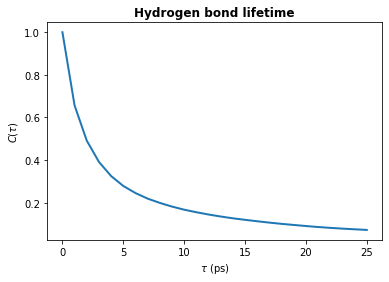

In [7]:
tau_times = tau_frames * u.trajectory.dt
plt.plot(tau_times, hbond_lifetime, lw=2)

plt.title(r"Hydrogen bond lifetime", weight="bold")
plt.xlabel(r"$\tau\ \rm (ps)$")
plt.ylabel(r"$C(\tau)$")

plt.show()


## Calculating the time constant

To obtain the hydrogen bond lifetime, you can fit a biexponential to the time autocorrelation curve. We will fit the following biexponential:

<center>
$$
A\exp(-t / \tau_1) + B\exp(-t / \tau_2)
$$
</center>

where $\tau_1$ and $\tau_2$ represent two time constants - one corresponding to a short-timescale process and the other to a longer timescale process. $A$ and $B$ will sum to $1$, and they represent the relative importance of the short- and longer-timescale processes in the overall autocorrelation curve.


In [8]:
def fit_biexponential(tau_timeseries, ac_timeseries):
    """Fit a biexponential function to a hydrogen bond time autocorrelation function
    
    Return the two time constants
    """
    from scipy.optimize import curve_fit
    
    def model(t, A, tau1, B, tau2):
        """Fit data to a biexponential function.
        """
        return A * np.exp(-t / tau1) + B * np.exp(-t / tau2)

    params, params_covariance = curve_fit(model, tau_timeseries, ac_timeseries, [1, 0.5, 1, 2])
    
    fit_t = np.linspace(tau_timeseries[0], tau_timeseries[-1], 1000)
    fit_ac = model(fit_t, *params)

    return params, fit_t, fit_ac


In [9]:
params, fit_t, fit_ac = fit_biexponential(tau_frames, hbond_lifetime)

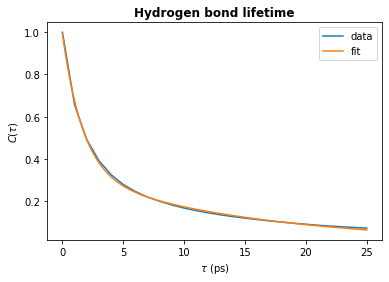

In [10]:
# Plot the fit
plt.plot(tau_times, hbond_lifetime, label="data")
plt.plot(fit_t, fit_ac, label="fit")

plt.title(r"Hydrogen bond lifetime", weight="bold")
plt.xlabel(r"$\tau\ \rm (ps)$")
plt.ylabel(r"$C(\tau)$")

plt.legend()
plt.show()


In [11]:
# Check the decay time constant
A, tau1, B, tau2 = params
time_constant = A * tau1 + B * tau2
print(f"time_constant = {time_constant:.2f} ps")


time_constant = 6.14 ps


## Intermittent lifetime

The above example shows you how to calculate the continuous hydrogen bond lifetime. This means that the hydrogen bond must be present at every frame from $t_0$ to $t_0 + \tau$. To allow for small fluctuations in the DA distance or DHA angle, the intermittent hydrogen bond lifetime may be calculated. This allows a hydrogen bond to break for up to a specified number of frames and still be considered present.

In the `lifetime` method, the `intermittency` argument is used to set the maxium number of frames for which a hydrogen bond is allowed to break. The default is `intermittency=0`, which means that if a hydrogen bond is missing at any frame between $t_0$ and $t_0 + \tau$, it will not be considered present at $t_0+\tau$. This is equivalent to the continuous lifetime. However, with a value of `intermittency=2`, all hydrogen bonds are allowed to break for up to a maximum of consecutive two frames.

Below we see how changing the intermittency affects the hydrogen bond lifetime.


In [12]:
tau_max = 25
window_step = 1
intermittencies = [0, 1, 10, 100]


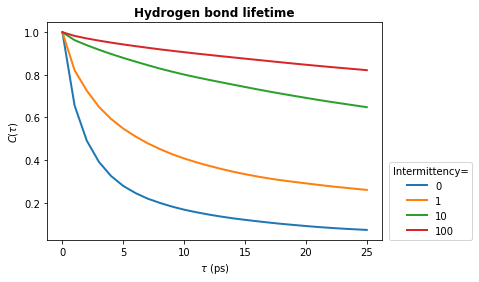

In [13]:
for intermittency in intermittencies:
    
    tau_frames, hbond_lifetime = hbonds.lifetime(
        tau_max=tau_max,
        window_step=window_step,
        intermittency=intermittency
    )
    
    times_times = tau_frames * u.trajectory.dt
    plt.plot(times_times, hbond_lifetime, lw=2, label=intermittency)
    
plt.title(r"Hydrogen bond lifetime", weight="bold")
plt.xlabel(r"$\tau\ \rm (ps)$")
plt.ylabel(r"$C(\tau)$")
    
plt.legend(title="Intermittency=", loc=(1.02, 0.0))
plt.show()


## Hydrogen bond lifetime of individual hydrogen bonds

Let's first find the 10 most prevalent hydrogen bonds.

In [14]:
hbonds = HydrogenBondAnalysis(universe=u)

In [15]:
hbonds.run(verbose=True)

  0%|          | 0/98 [00:00<?, ?it/s]

In [16]:
# Print donor, hydrogen, acceptor and count info for these hbonds
counts = hbonds.count_by_ids()
for donor, hydrogen, acceptor, count in counts[:10]:
    d, h, a = u.atoms[donor], u.atoms[hydrogen], u.atoms[acceptor]
    print(f"{d.resname}-{d.resid}-{d.name}\t{h.name}\t{a.resname}-{a.resid}-{a.name}\tcount={count}")


ARG-71-NH2	HH22	ASP-76-OD1	count=98
TYR-193-OH	HH	GLU-108-OE1	count=97
ARG-2-NH1	HH11	ASP-104-OD1	count=96
THR-199-OG1	HG1	ASP-197-OD1	count=95
TYR-24-OH	HH	GLY-214-OT2	count=95
TYR-133-OH	HH	ASP-146-OD1	count=95
ARG-206-NE	HE	GLU-210-OE1	count=93
ARG-124-NH2	HH22	GLU-143-OE1	count=93
LYS-200-NZ	HZ2	ASP-208-OD2	count=93
LYS-211-NZ	HZ3	GLU-204-OE1	count=92


Now we'll calculate the lifetime of these hydrogen bonds. To do this, the simplest way is to run `HydrogenBondAnalysis` for each hydrogen bond then use the `lifetime` method. It is very efficient to find hydrogen bonds between two specific atoms, especially with `update_selections=False`.

In [17]:
tau_max = 25
window_step = 1
intermittency = 0


In [18]:
hbond_lifetimes = []
labels = [] # for plotting

for hbond in counts[:10]:
        
        # find hbonds between specific atoms
        d_ix, h_ix, a_ix = hbond[:3]
        tmp_hbonds = HydrogenBondAnalysis(
            universe=u,
            hydrogens_sel=f"index {h_ix}",
            acceptors_sel=f"index {a_ix}",
            update_selections=False
        )
        tmp_hbonds.run()
        
        # calculate lifetime
        taus, hbl, = tmp_hbonds.lifetime(
            tau_max=tau_max,
            intermittency=intermittency
        )
        hbond_lifetimes.append(hbl)
        
        # label for plotting
        donor, acceptor = u.atoms[d_ix], u.atoms[a_ix]
        label = f"{donor.resname}:{donor.resid} to {acceptor.resname}:{acceptor.resid}"
        labels.append(label)

hbond_lifetimes = np.array(hbond_lifetimes)
labels = np.array(labels)


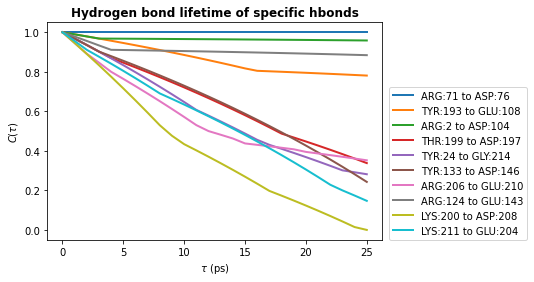

In [19]:
# Plot the lifetimes
times = taus * u.trajectory.dt
for hbl, label in zip(hbond_lifetimes, labels):
    plt.plot(times, hbl, label=label, lw=2)

plt.title(r"Hydrogen bond lifetime of specific hbonds", weight="bold")
plt.xlabel(r"$\tau\ \rm (ps)$")
plt.ylabel(r"$C(\tau)$")

plt.legend(ncol=1, loc=(1.02, 0))
plt.show()


<div class="alert alert-info">
    
**Note**
    
The shape of these curves indicates we have poor statistics in our lifetime calculations - we used only 100 frames and consider a single hydrogen bond.
    
The curve should decay smoothly toward 0, as seen in the first hydrogen bond lifetime plot we produced in this notebook. If the curve does not decay smoothly, more statistics are required either by increasing the value of `tau_max`, using a greater number of time origins, or increasing the length of your simulation.
    
See [Gowers and Carbonne (2015)](https://doi.org/10.1063/1.4922445) for further discussion on hydrogen bonds lifetimes.
</div>

## References

[1] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[2] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[3] Paul Smith, Robert&nbsp;M. Ziolek, Elena Gazzarrini, Dylan&nbsp;M. Owen, and Christian&nbsp;D. Lorenz.
On the interaction of hyaluronic acid with synovial fluid lipid membranes.
<em>Phys. Chem. Chem. Phys.</em>, 21(19):9845-9857, 2018.
URL: <a href="http://dx.doi.org/10.1039/C9CP01532A">http://dx.doi.org/10.1039/C9CP01532A

[4] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[5] Richard&nbsp;J. Gowers and Paola Carbonne.
A multiscale approach to model hydrogen bonding: The case of polyamide.
<em>J. Chem. Phys.</em>, 142:224907, June 2015.
URL: <a href="https://doi.org/10.1063/1.4922445">https://doi.org/10.1063/1.4922445